In [17]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader

In [109]:
START = 493 - 25
SIZE = 25
n_range = range(START, START + SIZE)
N = len(n_range)
SXM_PATH = ["electromigration_16/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 13
min_mass = 2
max_mass = 8
min_size = 0.5
max_ecc = 1
separation = 5
searchRange = 150
# frames[0] = frames[0][::-1]

Frame 24: 29 features


<Figure size 720x360 with 0 Axes>

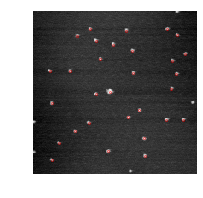

In [110]:
f = tp.batch(frames[:], molecule_size, minmass=min_mass, separation=separation)
plt.figure()

fig=plt.figure(figsize=(4, 3))
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
ln, = ax1.plot([], [], lw=3)
plt.axis('off')

def update(i):
    tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 0.5}, ax=ax1)
    for line in ax1.lines[:-1]:
        line.set_marker(None)
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=500)
ani

Frame 24: 29 trajectories present.


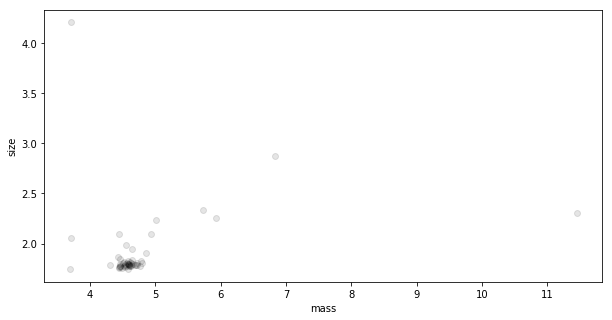

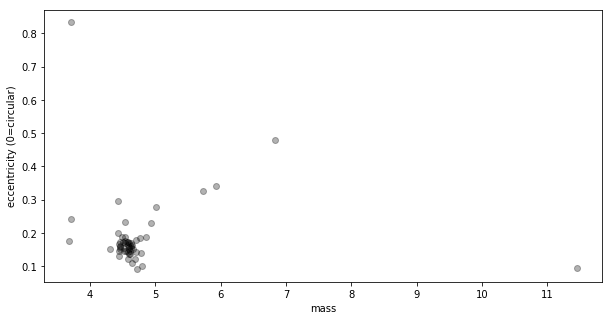

In [111]:

t = tp.link(f, search_range=100, adaptive_stop=2, adaptive_step=0.99)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [112]:
t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
t2 = tp.filter_stubs(t, 1)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 53
After: 53


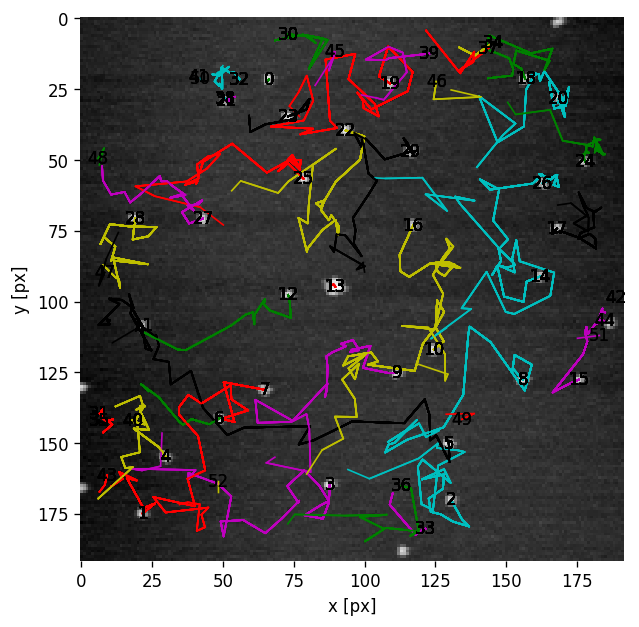

In [113]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

fig=plt.figure(figsize=(8, 6), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
plt.axis('on')
ln, = ax1.plot([], [], lw=3)
ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])

def update(i):
#     tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames[i], label=False, ax=ax1)
    tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames[i], label=True, ax=ax1)
    ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=1000)
ani

In [36]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
d.loc[0] = [0, 0]
# print(d)


In [37]:
d * frames.meters_per_pixel * 1e9

,y,x
frame,,
1,0.218242,0.350054
2,-1.446488,-1.214211
3,-1.877854,-2.520774
4,-2.114670,-0.658970
5,-4.615292,-0.414889
...,...,...
96,-6.351513,-21.099454
97,-5.121073,-26.274934
98,-9.191564,-34.558146


In [39]:
drifts = []

In [40]:
drifts.append(d)

In [41]:
NM_PER_PIXEL = frames.meters_per_pixel * 1e9

              y          x
frame                     
1           NaN        NaN
2           NaN        NaN
3           NaN        NaN
4           NaN        NaN
5           NaN        NaN
...         ...        ...
96     6.016510 -15.041348
97     3.828700 -16.480347
98     0.600712 -18.540079
99    -2.070003 -20.880811
0     -4.396197 -19.869332

[100 rows x 2 columns]


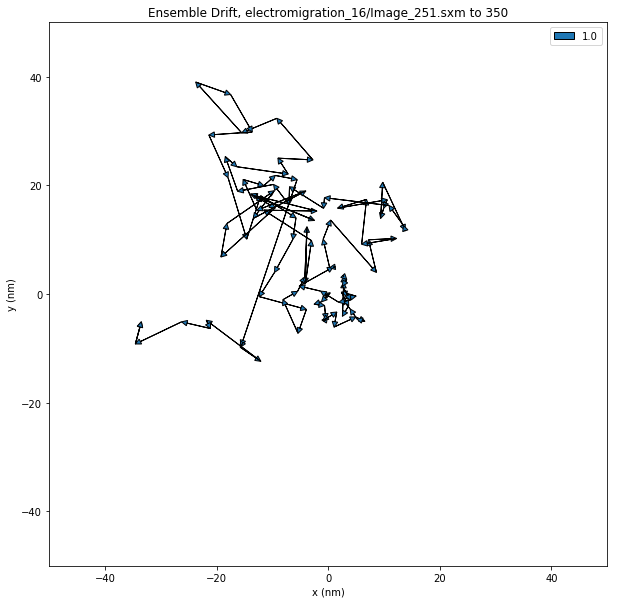

In [79]:
plt.figure(figsize=(10, 10))
colors = ['r', 'k', 'b', 'g', 'tab:orange', 'tab:purple']
labels = [1.0]
arrs = []
j = 0
for d in drifts:
    print(_)
#     sns.scatterplot(x='x', y='y', data=d * NM_PER_PIXEL, alpha=0.0)
    for i in range(1, len(d)):
        d0, d1 = d.loc[i - 1] * NM_PER_PIXEL, d.loc[i] * NM_PER_PIXEL
        plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
        shape='full', length_includes_head=True, 
        zorder=0, head_length=1, head_width=1,)
    else:
        arrs.append(plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
        shape='full', length_includes_head=True, 
        zorder=0, head_length=1, head_width=1,))
    j += 1
new_labels, arrs = zip(*sorted(zip(labels, arrs)))
plt.legend(arrs, new_labels)
plt.title("Ensemble Drift, " + SXM_PATH[0] + " to {}".format(n_range[-1]))
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

In [ ]:
import scipy
endpoints = np.array([d.loc[14] * NM_PER_PIXEL for d in drifts])
mag_displace = np.linalg.norm(endpoints, 2, axis=1)
new_labels, mag_displace = zip(*sorted(zip(labels, mag_displace)))
def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c


popt, pcov = scipy.optimize.curve_fit(exponenial_func, new_labels, mag_displace)

xx = np.linspace(0.95, 1.2, 100)
yy = exponenial_func(xx, *popt)

plt.plot(new_labels, np.array(mag_displace) / 1.5, 'o')
plt.plot(xx, yy / 1.5)
plt.title('drift velocity')
plt.ylabel('velocity (micron / s)')
plt.xlabel('Source Drain (V)')

In [701]:
displacement_df = tp.relate_frames(t2, 0, 1) * NM_PER_PIXEL
for i in range(1, SIZE - 1):
    displacement_df = displacement_df.append(tp.relate_frames(t2, i, i + 1) * NM_PER_PIXEL, ignore_index=True)

In [702]:
displacement_df

,x,y,x_b,y_b,dx,dy,dr,direction
0,75.473346,1.490502,75.633310,1.367345,0.159964,-0.123158,0.201882,-0.341729
1,78.086529,88.048207,77.104493,88.573592,-0.982036,0.525386,1.113744,1.380386
2,24.596394,86.291147,24.580440,86.129880,-0.015954,-0.161268,0.162055,-0.869480
3,59.284806,81.260350,58.821461,81.090970,-0.463345,-0.169380,0.493334,-1.453710
4,82.708021,77.433804,82.254327,77.538341,-0.453695,0.104536,0.465582,1.518299
...,...,...,...,...,...,...,...,...
438,51.984182,35.624614,51.954274,35.608532,-0.029908,-0.016082,0.033958,-1.379292
439,22.264871,35.858664,21.457806,37.456963,-0.807065,1.598299,1.790506,1.061666
440,9.972340,36.770245,9.828440,36.462729,-0.143900,-0.307516,0.339519,-1.046078
441,66.782942,40.716817,67.068839,40.635139,0.285897,-0.081679,0.297335,-0.144937


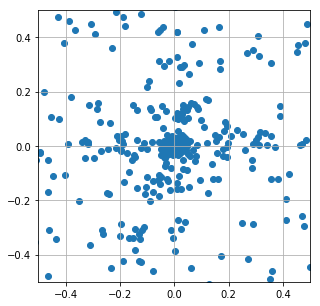

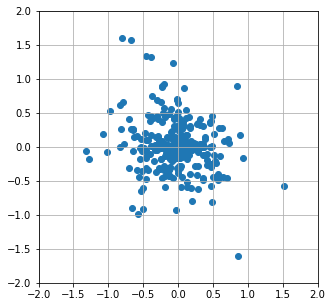

In [703]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.grid()
ax.set_aspect('equal', 'box')
plt.figure(figsize=(5,5));
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
ax.set_aspect('equal', 'box')

# WAIT TIME ANALYSIS

In [264]:
t4 = t3.drop(columns='frame').reset_index().sort_values(['particle', 'frame'])
t4['step_y'] = t4.groupby('particle').diff()['y']
t4['step_x'] = t4.groupby('particle').diff()['x']

(-10, 10)

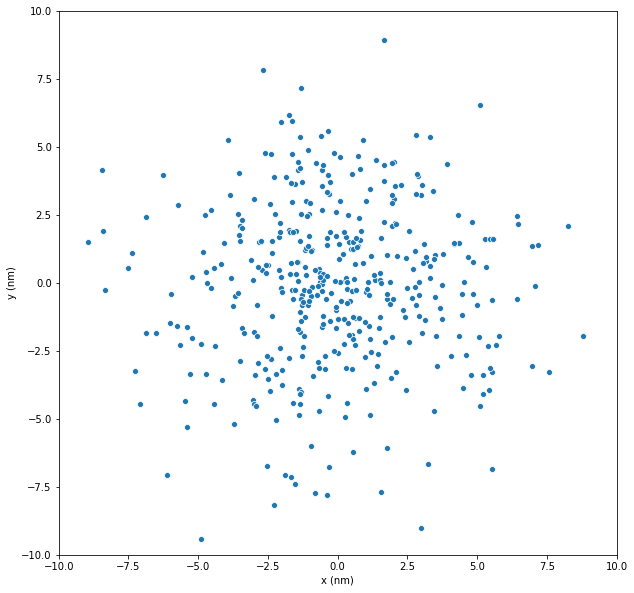

In [265]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='step_x', y='step_y', data=t4 * NM_PER_PIXEL)
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [278]:
t4[t4.particle == 2]

KeyboardInterrupt: 

In [277]:
t4['step_size'] = np.sqrt(t4['step_x'] ** 2 + t4['step_y'] ** 2)
t4['big_step'] = t4['step_size'] > 10
a = ~t4['big_step']
b = a.cumsum()
c = b-b.where(~a).ffill().fillna(1).astype(int)
t4['wait'] = c
t4['wait'] = t4['wait'].replace(0, np.nan).ffill(limit=1)
t4[t4['big_step']].dropna()

,frame,y,x,mass,size,ecc,signal,raw_mass,ep,particle,step_y,step_x,step_size,big_step,wait
72,2,174.098734,39.690340,4.808615,1.830630,0.093042,0.369189,14.487905,-1.172080,2,-10.081164,6.290360,11.882697,True,17.0
229,6,158.248674,33.150365,4.715513,1.801042,0.192747,0.374976,14.515177,-0.966156,2,-11.339132,-4.092308,12.054995,True,3.0
402,12,212.608462,14.802080,4.760476,1.791610,0.163146,0.374454,13.812615,-0.620764,2,14.306489,-0.865293,14.332632,True,1.0
182,5,195.301694,97.477209,4.701746,1.843765,0.202021,0.366593,20.643393,0.374027,3,9.568686,4.251453,10.470654,True,7.0
248,7,190.415212,104.189439,4.666769,1.778071,0.221526,0.375381,21.852424,0.314147,3,-6.905670,10.350241,12.442499,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,13,227.315411,178.502980,4.789136,1.720998,0.055577,0.390135,29.978425,0.136142,46,0.603529,-13.413194,13.426765,True,5.0
381,11,112.923520,152.648532,4.625103,1.758631,0.238251,0.381452,25.724478,0.165563,47,-10.487403,13.330128,16.961071,True,2.0
464,14,133.032353,129.325124,4.561296,1.730998,0.146539,0.373554,25.029457,0.196148,47,10.613575,-21.625339,24.089484,True,2.0
412,12,103.788411,227.107142,4.748199,1.724852,0.143991,0.386731,34.964996,0.083019,48,-12.947515,-5.680163,14.138684,True,1.0
